<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Explainable-Ai-for-The-ML-Models/blob/main/Vit_Integrated%20Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install torch torchvision transformers matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
from transformers import ViTForImageClassification

# Define your model (ensure this matches the architecture used when saving)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")

# Load the saved model weights
model_path = '/content/drive/MyDrive/VIT_model.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
from PIL import Image
from transformers import ViTImageProcessor

# Load the image you want to process
image_path = '/content/drive/MyDrive/Dataset4/Training/Fake/14.jpg'
image = Image.open(image_path)

# Preprocess the image for ViT
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
inputs = processor(images=image, return_tensors="pt")
input_image = inputs["pixel_values"].squeeze(0)  # Remove batch dimension
input_image = input_image.unsqueeze(0)  # Add batch dimension back for input


In [9]:
def integrated_gradients(input_image, model, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_image)  # Default baseline: black image

    # Compute the scaling factor for interpolation
    alphas = torch.linspace(0, 1, steps).unsqueeze(1).unsqueeze(2).unsqueeze(3).to(input_image.device)
    # Interpolate between baseline and input image
    scaled_inputs = baseline + alphas * (input_image - baseline)

    # Compute gradients
    scaled_inputs.requires_grad_()
    model.zero_grad()
    outputs = model(scaled_inputs).logits  # Get model output (logits)

    # Calculate the gradients of the predicted class (we'll use the top prediction)
    preds = torch.argmax(outputs, dim=-1)
    one_hot = torch.zeros_like(outputs)
    one_hot.scatter_(1, preds.unsqueeze(1), 1)  # One-hot vector for predicted class
    outputs.backward(gradient=one_hot, retain_graph=True)

    # Compute the gradients
    grads = scaled_inputs.grad.detach()

    # Average the gradients across all steps
    avg_grads = grads.mean(dim=0)  # Mean gradients for all the scaled inputs

    # Compute Integrated Gradients: sum of gradients along the path
    integrated_gradients = (input_image - baseline) * avg_grads

    return integrated_gradients


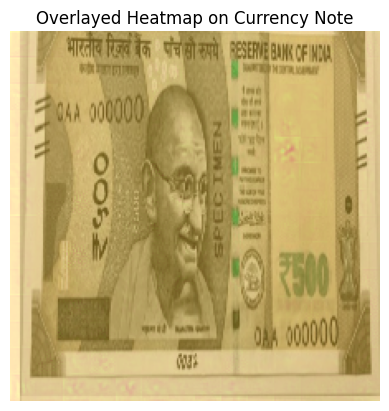

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Call the integrated_gradients function to get the integrated gradients
ig = integrated_gradients(input_image, model) # This line is added to call the function

# Convert the integrated gradients to a numpy array
ig = ig.cpu().detach().numpy()  # Convert to numpy and detach from the computation graph

# Remove the batch dimension (index 0) before normalization
ig = ig.squeeze(0)  # Removing batch dimension

# Normalize IG to [0, 255]
ig_min = np.min(ig)
ig_max = np.max(ig)
ig_normalized = (ig - ig_min) / (ig_max - ig_min)  # Normalize to [0, 1]
ig_normalized = (ig_normalized * 255).astype(np.uint8)  # Convert to [0, 255]

# Apply a colormap (e.g., "jet" or "hot")
# Transpose to (height, width, channels) format
heatmap = cv2.applyColorMap(ig_normalized.transpose(1, 2, 0), cv2.COLORMAP_JET)

# Assuming 'image' is your original PIL Image
image_np = np.array(image)  # Convert PIL Image to numpy array

# Ensure the image is in the same size as the heatmap
image_resized = cv2.resize(image_np, (heatmap.shape[1], heatmap.shape[0]))  # Resize if needed

# Overlay the heatmap on the image
heatmap_overlay = cv2.addWeighted(image_resized, 0.7, heatmap, 0.3, 0)

# Display the result
plt.imshow(heatmap_overlay)
plt.axis('off')
plt.title("Overlayed Heatmap on Currency Note")
plt.show()